In [34]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import precision_score, recall_score, roc_curve, confusion_matrix, accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense
from keras_tuner import RandomSearch
from sklearn.svm import SVC 
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from mlxtend.classifier import StackingCVClassifier
import seaborn as sns
import itertools

In [11]:
# converting files into dataframes
excelfile1 = 'recruiting_zeta-disease_training-data.xlsx'
excelfile2 = 'recruiting_zeta-disease_test-data.xlsx'
full_df = pd.read_excel(excelfile1)
pred_df = pd.read_excel(excelfile2)

In [12]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 800 non-null    int64  
 1   weight              800 non-null    int64  
 2   bmi                 800 non-null    float64
 3   blood_pressure      800 non-null    int64  
 4   insulin_test        800 non-null    int64  
 5   liver_stress_test   800 non-null    float64
 6   cardio_stress_test  800 non-null    int64  
 7   years_smoking       800 non-null    int64  
 8   zeta_disease        800 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 56.4 KB


In [13]:
full_df['zeta_disease'].value_counts()

0    521
1    279
Name: zeta_disease, dtype: int64

In [14]:
full_df.head(10)

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,54,189,27.1,80,0,1.5038,0,10,0
1,23,150,38.5,68,71,0.3868,55,2,0
2,47,186,29.9,90,0,0.2728,0,7,0
3,18,150,30.8,70,1033,0.6598,56,0,0
4,24,160,32.4,74,125,0.7608,59,2,0
5,49,158,27.0,80,0,0.3218,0,2,1
6,20,154,27.8,64,116,0.5168,53,0,0
7,37,167,34.5,88,145,0.4658,54,1,1
8,21,162,34.8,80,132,0.2798,75,1,0
9,19,186,31.2,70,0,1.2448,0,4,1


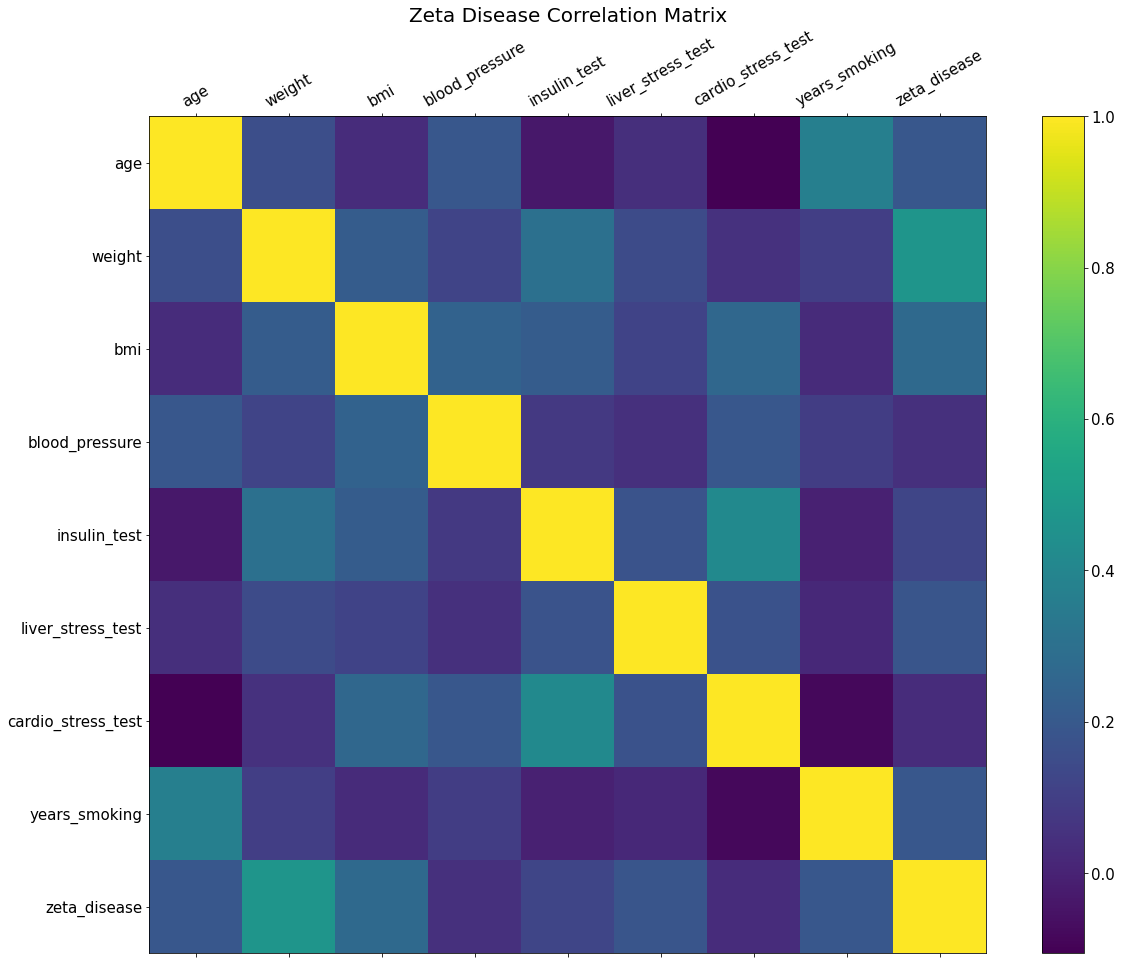

In [19]:
f = plt.figure(figsize=(20,15))
plt.matshow(full_df.corr(), fignum = f.number)
plt.xticks(range(full_df.select_dtypes(['number']).shape[1]), full_df.select_dtypes(['number']).columns, fontsize = 15, rotation = 30)
plt.yticks(range(full_df.select_dtypes(['number']).shape[1]), full_df.select_dtypes(['number']).columns, fontsize = 15)
cb = plt.colorbar()
cb.ax.tick_params(labelsize = 15)
plt.title('Zeta Disease Correlation Matrix', fontsize = 20)
plt.show()

In [22]:
# Separate features and labels
features = ['age','weight','bmi','blood_pressure','insulin_test','liver_stress_test','cardio_stress_test','years_smoking']
label = 'zeta_disease'
X, y = full_df[features].values, full_df[label].values

for i in range(0,5):
    print('Patient:', str(i+1), '\n Patient Information:', list(X[i]))

Patient: 1 
 Patient Information: [54.0, 189.0, 27.1, 80.0, 0.0, 1.5038, 0.0, 10.0]
Patient: 2 
 Patient Information: [23.0, 150.0, 38.5, 68.0, 71.0, 0.3868, 55.0, 2.0]
Patient: 3 
 Patient Information: [47.0, 186.0, 29.9, 90.0, 0.0, 0.2728, 0.0, 7.0]
Patient: 4 
 Patient Information: [18.0, 150.0, 30.8, 70.0, 1033.0, 0.6598, 56.0, 0.0]
Patient: 5 
 Patient Information: [24.0, 160.0, 32.4, 74.0, 125.0, 0.7608, 59.0, 2.0]


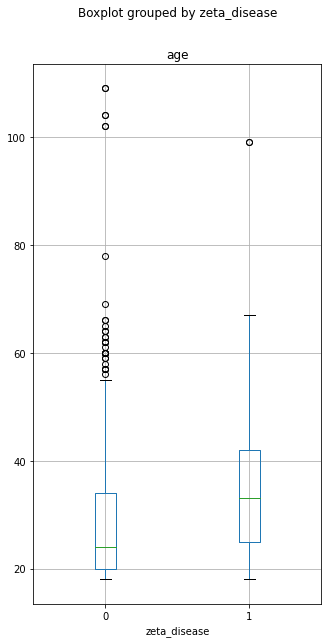

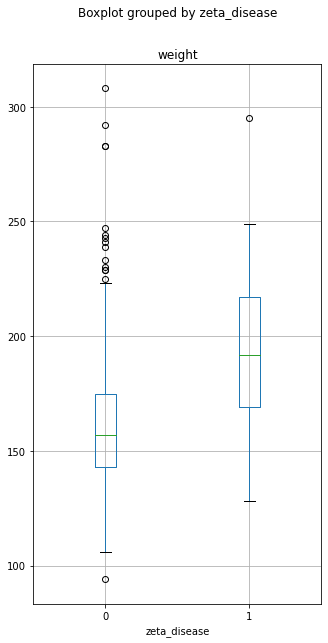

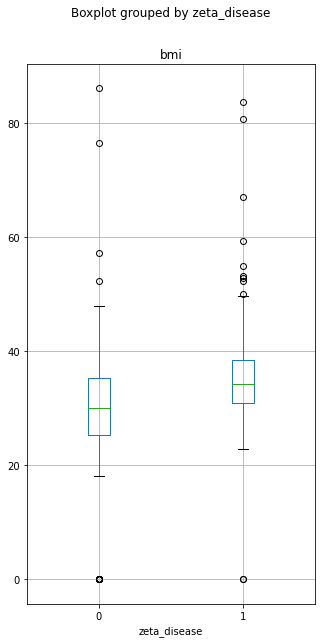

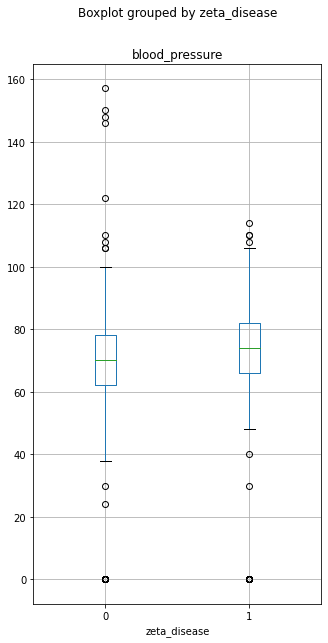

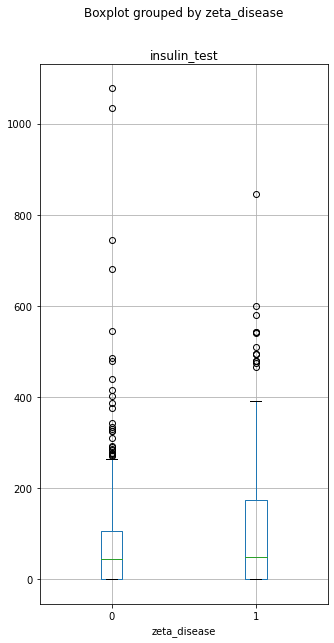

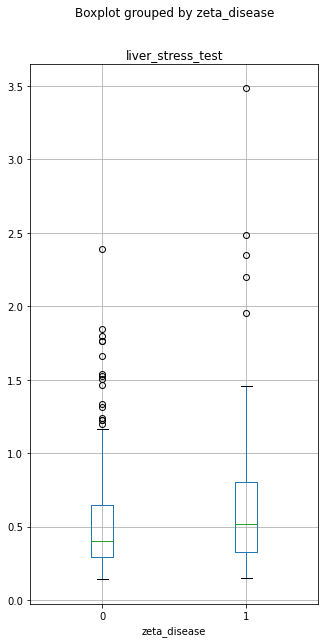

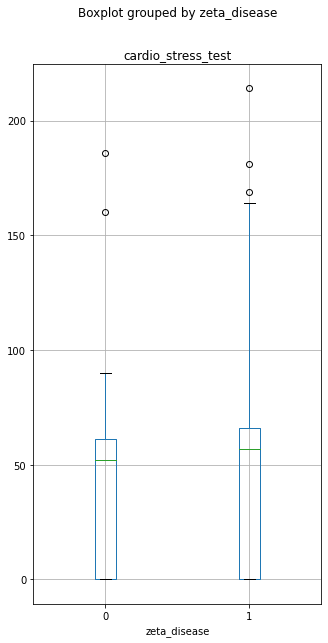

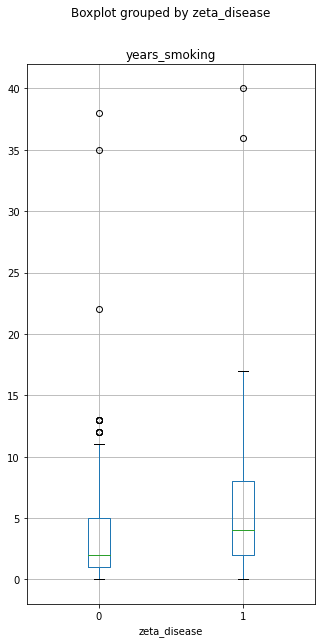

In [25]:
%matplotlib inline

features = ['age','weight','bmi','blood_pressure','insulin_test','liver_stress_test','cardio_stress_test','years_smoking']
for col in features:
    full_df.boxplot(column = col, by = 'zeta_disease', figsize = (5,10))
    plt.title(col)
plt.show()

In [26]:
# pulling out numeric features to normalize
numeric_feats = ['age','weight','bmi','blood_pressure','insulin_test','liver_stress_test','cardio_stress_test','years_smoking']
df_numeric_feats = pd.DataFrame(full_df, columns = numeric_feats)
df_categ_feats = full_df.drop(columns = numeric_feats)

# normalizing numeric features and converting back to dataframe
min_max_scaler = preprocessing.MinMaxScaler()
normalized_numeric_feats = min_max_scaler.fit_transform(df_numeric_feats)
normalized_numeric_feats = pd.DataFrame(normalized_numeric_feats, columns = numeric_feats, index = df_categ_feats.index)

# creating new dataframe with categorical features and the normalized numeric features
df_numeric_norm = pd.concat([normalized_numeric_feats,df_categ_feats], axis=1)

In [27]:
# splitting normalized data into training and test sets
X_normalized = df_numeric_norm.drop('zeta_disease', axis=1).values
y = df_numeric_norm['zeta_disease'].values
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=0)
print('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))

Training cases: 640
Test cases: 160


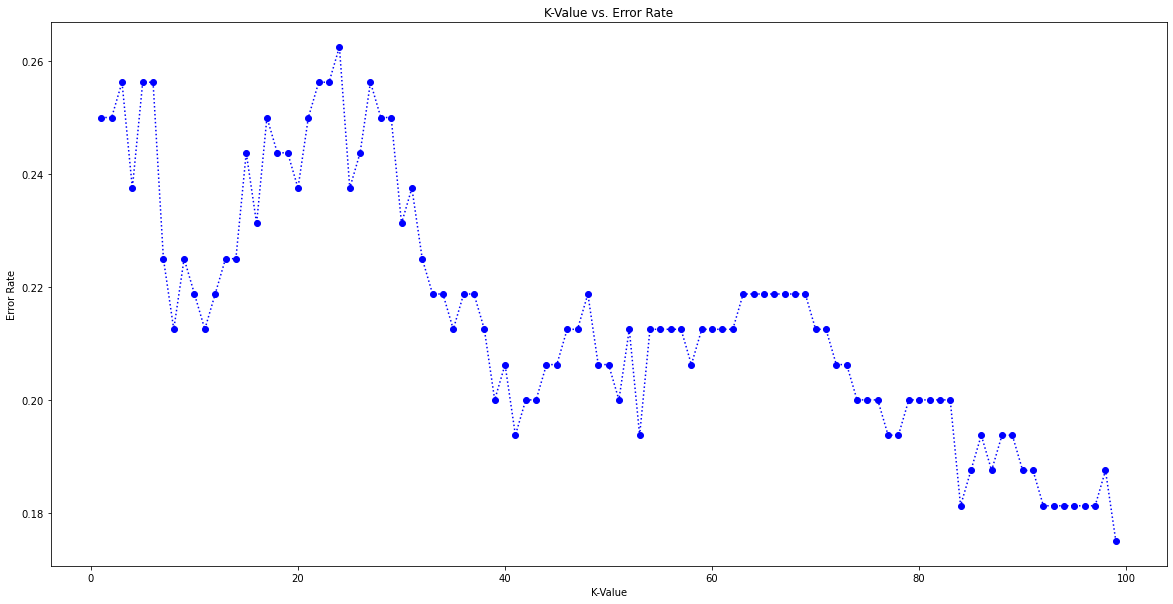

In [31]:
# Normalized KNN classifier and error rate
error_rate = []
for i in range(1,100):
    knn = KNeighborsClassifier(n_neighbors = i)
    model = knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
plt.figure(figsize=(20,10))
plt.plot(range(1,100),error_rate, linestyle = 'dotted',marker = 'o', color = 'b')
plt.xlabel('K-Value')
plt.ylabel('Error Rate')
plt.title('K-Value vs. Error Rate')
plt.show()

In [37]:
# Logistic Regression classifier

param_grid = {'C': np.arange(.5, 1, 5)}

logclass = LogisticRegression(penalty='l1', solver='liblinear')   
logclass_search = GridSearchCV(logclass, param_grid, cv=5)
logclass_search.fit(X_train, y_train)

print('Best C Value', logclass_search.best_params_, '\n')

y_pred = logclass_search.predict(X_test)

print('Logistic Regression Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Actual: 0', 'Actual: 1'], columns = ['Predicted: 0', 'Predicted: 1']), '\n')
print('Logistic Regression Classification Report:')
print(classification_report(y_test, y_pred))

Best C Value {'C': 0.5} 

Logistic Regression Confusion Matrix:
           Predicted: 0  Predicted: 1
Actual: 0           107             9
Actual: 1            24            20 

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       116
           1       0.69      0.45      0.55        44

    accuracy                           0.79       160
   macro avg       0.75      0.69      0.71       160
weighted avg       0.78      0.79      0.78       160



In [38]:
# Set regularization rate
reg = 0.01

#train model
model = LogisticRegression(C=1/reg, solver = 'liblinear').fit(X_train, y_train)
print(model)

LogisticRegression(C=100.0, solver='liblinear')


In [40]:
predictions = model.predict(X_test)
print('Predicted Labels: ', predictions)
print('Actual Labels: ',y_test)

Predicted Labels:  [0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 1 0 0]
Actual Labels:  [0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 1
 1 1 0 1 0 0 0 0 0 0 0 0]


In [41]:
print('Accuracy: {0:2%}'.format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))

Accuracy: 82.500000%
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       116
           1       0.79      0.50      0.61        44

    accuracy                           0.82       160
   macro avg       0.81      0.72      0.75       160
weighted avg       0.82      0.82      0.81       160



In [42]:
print("Overall Precision: ",precision_score(y_test,predictions))
print("Overall Recall: ",recall_score(y_test,predictions))
matrix = confusion_matrix(y_test, predictions)
print(matrix)

Overall Precision:  0.7857142857142857
Overall Recall:  0.5
[[110   6]
 [ 22  22]]


In [43]:
y_scores = model.predict_proba(X_test)
print(y_scores)

[[0.75575729 0.24424271]
 [0.65542551 0.34457449]
 [0.24479032 0.75520968]
 [0.90406485 0.09593515]
 [0.8575371  0.1424629 ]
 [0.89768278 0.10231722]
 [0.67210378 0.32789622]
 [0.92688839 0.07311161]
 [0.2809431  0.7190569 ]
 [0.20008865 0.79991135]
 [0.56156634 0.43843366]
 [0.54490525 0.45509475]
 [0.63262206 0.36737794]
 [0.51834619 0.48165381]
 [0.85078599 0.14921401]
 [0.83577021 0.16422979]
 [0.8340376  0.1659624 ]
 [0.31311228 0.68688772]
 [0.89237361 0.10762639]
 [0.70775626 0.29224374]
 [0.94420072 0.05579928]
 [0.81481747 0.18518253]
 [0.91863836 0.08136164]
 [0.77075425 0.22924575]
 [0.80383705 0.19616295]
 [0.70858906 0.29141094]
 [0.80287698 0.19712302]
 [0.54845028 0.45154972]
 [0.87389415 0.12610585]
 [0.71599504 0.28400496]
 [0.66891595 0.33108405]
 [0.84053193 0.15946807]
 [0.92725631 0.07274369]
 [0.73578926 0.26421074]
 [0.11673205 0.88326795]
 [0.23051803 0.76948197]
 [0.85065464 0.14934536]
 [0.95920862 0.04079138]
 [0.70738621 0.29261379]
 [0.75346787 0.24653213]


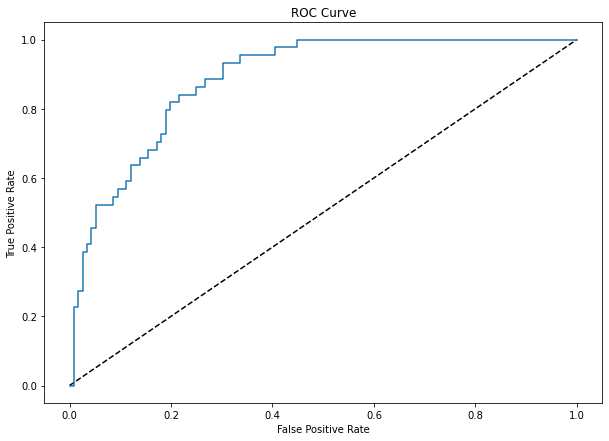

In [48]:
%matplotlib inline

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize = (10,7))
# plot diagonal 50% line
plt.plot([0,1],[0,1],'k--')
# plot the FPR and TPR achieved by the model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [49]:
auc = roc_auc_score(y_test, y_scores[:,1])
print('AUC: ' + str(auc))

AUC: 0.8863636363636364


In [50]:
# Random Forest classifier

param_grid = {'n_estimators': np.arange(10, 2000, 10), 
                 'max_features': ['auto', 'sqrt'],
                 'max_depth': np.arange(10, 200, 10),
                 'criterion': ['gini', 'entropy'],
                 'bootstrap': [True, False]}

rf = RandomForestClassifier()
rf_randomsearch = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, cv = 5)
rf_randomsearch.fit(X_train, y_train)

y_pred = rf_randomsearch.predict(X_test)

print('Tuned Random Forest Parameters:', rf_randomsearch.best_params_, '\n')
print('Tuned Random Forest Score: {}.'.format(rf_randomsearch.best_score_.round(2)), '\n')

print('Random Forest Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Actual: 0', 'Actual: 1'], columns = ['Predicted: 0', 'Predicted: 1']), '\n')
print('Random Forest Classification Report:')
print(classification_report(y_test, y_pred), '\n')

/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove 

Tuned Random Forest Parameters: {'n_estimators': 640, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'gini', 'bootstrap': True} 

Tuned Random Forest Score: 0.77. 

Random Forest Confusion Matrix:
           Predicted: 0  Predicted: 1
Actual: 0           100            16
Actual: 1            15            29 

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       116
           1       0.64      0.66      0.65        44

    accuracy                           0.81       160
   macro avg       0.76      0.76      0.76       160
weighted avg       0.81      0.81      0.81       160
 



In [21]:
# preprocessing for numeric columns
numeric_features = [1,2,3,4,5,6,7]
numeric_transformer = Pipeline(steps=[('scaler',StandardScaler())])

# preprocessing for categorical features
categorical_features = [0]
categorical_transformer = Pipeline(steps=[('onehot',OneHotEncoder(handle_unknown='ignore'))])

# combine processing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# create preprocessing and training pipeline            
pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                           ('logregressor', LogisticRegression(C=1/reg, solver = 'liblinear'))])

# fit the pipeline to train the model
model = pipeline.fit(X_train, (y_train))
print(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [1, 2, 3, 4, 5, 6, 7]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0])])),
                ('logregressor',
                 LogisticRegression(C=100.0, solver='liblinear'))])


('Confusion Matrix:', array([[110,   6],
       [ 22,  22]]))
Accuracy: 0.825
Overall Precision: 0.7857142857142857
Overall Recall: 0.5
AUC: 0.8863636363636364


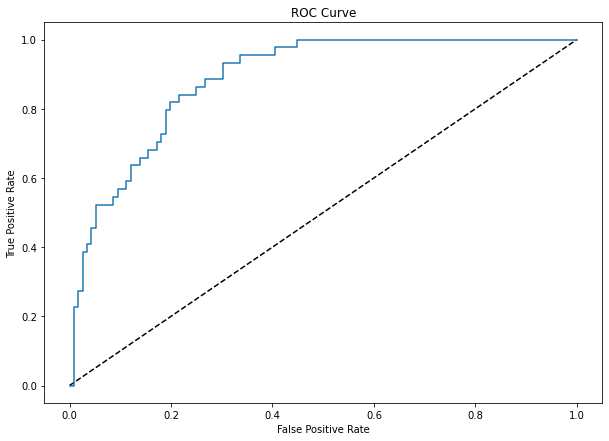

In [58]:
# get predictions from test data
predictions = model.predict(X_test)
y_scores = model.predict_proba(X_test)

# get evaluaton metrics
cm = confusion_matrix(y_test, predictions)
print(('Confusion Matrix:', cm))
print('Accuracy:',accuracy_score(y_test, predictions))
print('Overall Precision:',(precision_score(y_test, predictions)))
print('Overall Recall:',recall_score(y_test, predictions))
auc = roc_auc_score(y_test, y_scores[:,1])
print('AUC: ' + (str(auc)))

#calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

#plot ROC curve
fig = plt.figure(figsize=(10,7))
plt.plot([0,1],[0,1],'k--')

# plot model's FPR and TPR
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [23]:
# create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),('logregressor',RandomForestClassifier(n_estimators = 100))])

# fit the pipeline
model = pipeline.fit(X_train, (y_train))
print(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [1, 2, 3, 4, 5, 6, 7]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0])])),
                ('logregressor', RandomForestClassifier())])


('Confusion Matrix: \n', array([[110,   6],
       [ 22,  22]]), '\n')
Accuracy: 0.825
Overall Precision: 0.7857142857142857
Overall Recall: 0.5
AUC: 0.8863636363636364


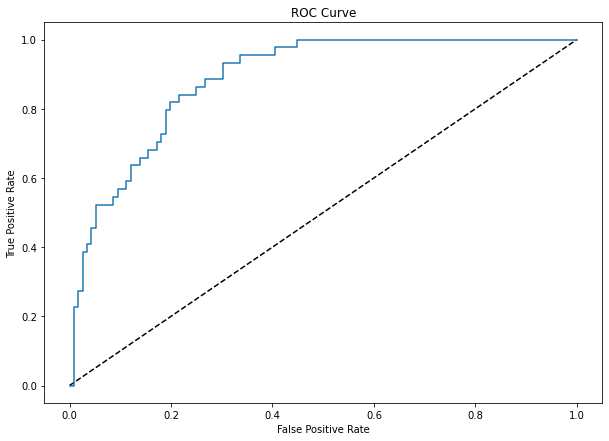

In [59]:
predictions = model.predict(X_test)
y_scores = model.predict_proba(X_test)
cm = confusion_matrix(y_test, predictions)
print(('Confusion Matrix: \n', cm, '\n'))
print('Accuracy:', accuracy_score(y_test, predictions))
print('Overall Precision:', precision_score(y_test, predictions))
print('Overall Recall:', recall_score(y_test, predictions))
auc = roc_auc_score(y_test, y_scores[:,1])
print('AUC: ' + str(auc))

#calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

#plot ROC curve
fig = plt.figure(figsize=(10,7))
plt.plot([0,1],[0,1],'k--')
# plot the model's FPR and TPR 
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [60]:
def model_tuned(x):
    model = Sequential()
    for i in range(x.Int('num_layers',3,10)):
        model.add(Dense(units=x.Int('units_' + str(i),
                        min_value = 9,
                        max_value = 128,
                        step = 16),
                        activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(
        optimizer = keras.optimizers.Adam(
            x.Choice('learning_rate', [0.01, 0.001, 0.0001])),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])
    return model

In [61]:
tuner1 = RandomSearch(model_tuned, objective = 'val_accuracy',max_trials = 5, executions_per_trial = 3)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [39]:
tuner1.search(X_train, y_train, epochs = 5, validation_data = (X_test, y_test))

Trial 5 Complete [00h 00m 05s]
val_accuracy: 0.8145833412806193

Best val_accuracy So Far: 0.8145833412806193
Total elapsed time: 00h 00m 23s
INFO:tensorflow:Oracle triggered exit


In [41]:
tuner1.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 7
units_0: 25
units_1: 121
units_2: 25
learning_rate: 0.001
units_3: 57
units_4: 25
units_5: 105
units_6: 89
units_7: 121
Score: 0.8145833412806193
Trial summary
Hyperparameters:
num_layers: 8
units_0: 41
units_1: 73
units_2: 73
learning_rate: 0.01
units_3: 89
units_4: 121
units_5: 89
units_6: 25
units_7: 9
Score: 0.8125
Trial summary
Hyperparameters:
num_layers: 4
units_0: 121
units_1: 89
units_2: 41
learning_rate: 0.001
units_3: 105
units_4: 57
units_5: 105
units_6: 41
units_7: 73
Score: 0.8104166587193807
Trial summary
Hyperparameters:
num_layers: 7
units_0: 89
units_1: 73
units_2: 121
learning_rate: 0.0001
units_3: 105
units_4: 25
units_5: 25
units_6: 89
units_7: 25
Score: 0.7416666746139526
Trial summary
Hyperparameters:
num_layers: 8
units_0: 9
units_1: 121
units_2: 9
learning_rate: 0.0001
units_3: 9
units_4: 9
units_5: 9
units_6: 9
units_7: 9
Score: 0.7291666865348816


In [69]:
X_train

array([[0.28571429, 0.54672897, 0.29616725, ..., 0.07424038, 0.24766355,
        0.25      ],
       [0.10989011, 0.37850467, 0.39256678, ..., 0.00299356, 0.23364486,
        0.05      ],
       [0.26373626, 0.31308411, 0.38095238, ..., 0.05597964, 0.        ,
        0.025     ],
       ...,
       [0.27472527, 0.18691589, 0.34494774, ..., 0.06555905, 0.28504673,
        0.3       ],
       [0.2967033 , 0.20560748, 0.40998839, ..., 0.08980692, 0.3271028 ,
        0.3       ],
       [0.03296703, 0.60747664, 0.51684088, ..., 0.17003443, 0.31308411,
        0.05      ]])

In [295]:
# Initializing Support Vector classifier
classifier1 = SVC(C = 5.0, 
                  degree = 1, 
                  gamma = "scale", 
                  kernel = "linear", 
                  probability = True, 
                  tol = 1.0, 
                  cache_size = 1, 
                  verbose = True, 
                  decision_function_shape = 'ovo', 
                  break_ties = True, 
                  random_state = 1)

# Initializing Multi-layer perceptron classifier
classifier2 = MLPClassifier(activation = "relu", 
                            alpha = 0.001,
                            learning_rate = "adaptive", 
                            max_iter = 150, 
                            random_state = 1, 
                            tol = 0.00005, 
                            warm_start = True, 
                            beta_2 = 0.4, 
                            epsilon = 0.000000005, 
                            n_iter_no_change = 15)

# Initialing Logistic Regression classifier
classifier3 = LogisticRegression(penalty = 'l2', 
                                 tol = 0.000001, 
                                 intercept_scaling = 0.001, 
                                 random_state = 1, 
                                 warm_start = True, 
                                 n_jobs = 1,
                                 solver = 'newton-cg', 
                                 multi_class = 'multinomial', 
                                 max_iter = 5, 
                                 C = 2)

# Initializing Random Forest classifier
classifier4 = RandomForestClassifier(n_estimators = 75, 
                                     criterion = "gini", 
                                     max_features = "sqrt", 
                                     min_samples_leaf = 0.005,
                                     n_jobs = -1, 
                                     random_state = 1000,
                                     min_weight_fraction_leaf = 0.005,
                                     oob_score = True,
                                     warm_start = True,
                                     verbose = 35,
                                     class_weight = 'balanced')

In [291]:
classifier = StackingClassifier(estimators = [classifier1, classifier2, classifier3, classifier4])
param_grid = {'classifier4__min_samples_leaf':[0.5,1,2],
              'classifier4__min_weight_fraction_leaf':[1.0,0.1,0.0,0.01,0.001],
              'classifier4__max_features':['sqrt','log2','auto',None],
              'classifier4__min_impurity_decrease':[0.0,0.1,0.01,0.001,0.0001,0.00001],
              'classifier4__bootstrap':[True,False],
              'classifier4__oob_score':[True, False],
              'classifier4__n_jobs':[1,-1,None],
              'classifier4__random_state':[1,None],
              'classifier4__verbose':[0,1,5,10,15],
              'classifier4__warm_start':[True, False],
              'classifier4__class_weight':['balanced','balanced_subsample',None],
              'classifier4__ccp_alpha':[0.0,0.01,0.001,0.0001,0.00001]}
grid_search = GridSearchCV(classifier, param_grid, n_jobs = -1, verbose = 10, cv = 5, scoring = 'accuracy').fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [ ]:
grid_search.best_params_

In [296]:
# Initializing the StackingCV classifier
sclf = StackingCVClassifier(classifiers = [classifier1, classifier2, classifier3, classifier4],
                            shuffle = False,
                            use_probas = True,
                            cv = 5,
                            meta_classifier = SVC(probability = True))

In [297]:
# Create list to store classifiers
classifiers = {"SVC": classifier1,
               "MLP": classifier2,
               "LOG": classifier3,
               "RF": classifier4,
               "Stack": sclf}

In [298]:
# Train classifiers
for key in classifiers:
    # Get classifier
    classifier = classifiers[key]
    
    # Fit classifier
    classifier.fit(X_train, y_train)
        
    # Save fitted classifier
    classifiers[key] = classifier

[LibSVM]

/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:789: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
[Parallel(n_jobs=-1)]:

building tree 1 of 75building tree 2 of 75building tree 3 of 75building tree 4 of 75


building tree 5 of 75building tree 6 of 75

building tree 7 of 75

building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75building tree 14 of 75building tree 15 of 75


building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75building tree 20 of 75

building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75building tree 30 of 75

building tree 31 of 75building tree 32 of 75building tree 33 of 75

building tree 34 of 75

building tree 35 of 75building tree 36 of 75

building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75building tree 41 of 75building tree 42 of 75building tree 43 of 75



building tree 44 of 

[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    0.2s
[Paralle

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.0s
[Para

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.0s
[Para

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
[LibSVM]

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0339s.) Setting b

building tree 1 of 75building tree 2 of 75
building tree 3 of 75

building tree 4 of 75building tree 5 of 75

building tree 6 of 75building tree 7 of 75

building tree 8 of 75
building tree 9 of 75building tree 10 of 75
building tree 11 of 75building tree 12 of 75building tree 13 of 75



building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75building tree 18 of 75

building tree 19 of 75
building tree 20 of 75building tree 21 of 75building tree 22 of 75

building tree 23 of 75

building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75building tree 28 of 75
building tree 29 of 75

building tree 30 of 75
building tree 31 of 75building tree 32 of 75

building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75building tree 37 of 75building tree 38 of 75building tree 39 of 75



building tree 40 of 75
building tree 41 of 75
building tree 42 of 75
building tree 43 of 75building tree 44 of 7

In [299]:
# Get results
results = pd.DataFrame()
for key in classifiers:
    # Make prediction on test set
    y_pred = classifiers[key].predict_proba(X_test)[:,1]
    
    # Save results as dataframe 
    results[f"{key}"] = y_pred

# Add the test set to the results
results["Target"] = y_test

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.0s
[Para

/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

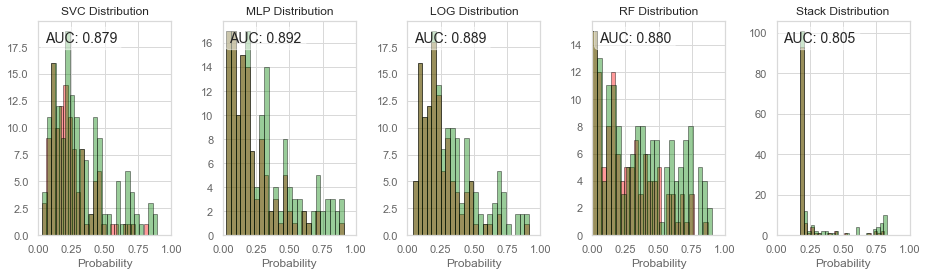

In [300]:
# Probability Distributions Figure
# Set graph style
sns.set(font_scale = 1)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

# Plot
f, ax = plt.subplots(figsize=(13, 4), nrows=1, ncols = 5)

for key, counter in zip(classifiers, range(5)):
    # Get predictions
    y_pred = results[key]
    
    # Get AUC
    auc = metrics.roc_auc_score(y_test, y_pred)
    textstr = f"AUC: {auc:.3f}"

    # Plot false distribution
    false_pred = results[results["Target"] == 0]
    sns.distplot(false_pred[key], hist=True, kde=False, 
                 bins=int(25), color = 'red',
                 hist_kws={'edgecolor':'black'}, ax = ax[counter])
    
    # Plot true distribution
    true_pred = results[results["Target"] == 1]
    sns.distplot(results[key], hist=True, kde=False, 
                 bins=int(25), color = 'green',
                 hist_kws={'edgecolor':'black'}, ax = ax[counter])
    
    
    # These are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    # Place a text box in upper left in axes coords
    ax[counter].text(0.05, 0.95, textstr, transform=ax[counter].transAxes, fontsize=14,
                    verticalalignment = "top", bbox=props)
    
    # Set axis limits and labels
    ax[counter].set_title(f"{key} Distribution")
    ax[counter].set_xlim(0,1)
    ax[counter].set_xlabel("Probability")

# Tight layout
plt.tight_layout()

In [302]:
# Define parameter grid 
params = {"meta_classifier__penalty": ['l1','l2','elasticnet',None],
          "meta_classifier__solver": ['newton-cg','lbfgs','liblinear','sag','saga'],
          "meta_classifier__activation": ['identity','logistic','tanh','relu'],
          "meta_classifier__learning_rate": ['constant','invscaling','adaptive']}


# Initialize GridSearchCV
grid = GridSearchCV(estimator = sclf, 
                    param_grid = params, 
                    cv = 5,
                    scoring = "roc_auc",
                    verbose = 10,
                    n_jobs = -1)

# Fit GridSearchCV
grid.fit(X_train, y_train)

# Making prediction on test set
y_pred = grid.predict_proba(X_test)[:,1]

# Getting AUC
auc = metrics.roc_auc_score(y_test, y_pred)

# Print results
print(f"The AUC of the tuned Stacking classifier is {auc:.3f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=-1)]: Batch computation too fast (0.0156s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elap

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.0s
[Para

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0697s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elap

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0152s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 tas

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
[LibSVM]

/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:789: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
[Parallel(n_jobs=-1)]:

building tree 1 of 75building tree 2 of 75

building tree 3 of 75
building tree 4 of 75building tree 5 of 75
building tree 6 of 75

building tree 7 of 75building tree 8 of 75

building tree 9 of 75
building tree 10 of 75
building tree 11 of 75building tree 12 of 75

building tree 13 of 75
building tree 14 of 75building tree 15 of 75

building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75building tree 20 of 75building tree 21 of 75

building tree 22 of 75

building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75building tree 27 of 75

building tree 28 of 75building tree 29 of 75

building tree 30 of 75
building tree 31 of 75building tree 32 of 75

building tree 33 of 75building tree 34 of 75

building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75
building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  63 out of  75 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  66 out of  75 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  69 out of  75 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  72 out of  75 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_j

In [304]:
# Classifier labels
classifier_labels = ["SVC", "MLP", "LOG", "RF"]

# Get all unique combinations
combo_classifiers = []
for ii in range(2, len(classifier_labels)+1):
    for subset in itertools.combinations(classifier_labels, ii):
        combo_classifiers.append(subset)

# Stack, tune, and evaluate stack of classifiers
for combo in combo_classifiers:
    # Get labels of classifier
    labels = list(combo)
     
    # Get classifiers
    classifier_combo = []
    for ii in range(len(labels)):
        label = classifier_labels[ii]
        classifier = classifiers[label]
        classifier_combo.append(classifier)

    # Initializing the Stacking classifier
    sclf = StackingCVClassifier(classifiers = classifier_combo,
                                shuffle = False,
                                use_probas = True,
                                cv = 5,
                                meta_classifier = SVC(probability = True),
                                n_jobs = -1)
    
    # Initialize the Grid Search
    grid = GridSearchCV(estimator = sclf, 
                        param_grid = params, 
                        cv = 5,
                        scoring = "roc_auc",
                        verbose = 0,
                        n_jobs = -1)

    # Fit the Grid Search
    grid.fit(X_train, y_train)
    
    # Make predictions on test set
    y_pred = grid.predict_proba(X_test)[:,1]
    
    # Get AUC
    acc = metrics.roc_auc_score(y_test, y_pred)
    
    # Print results
    print(f"AUC of stack {combo}: {auc:.3f}")

[LibSVM]

/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC of stack ('SVC', 'MLP'): 0.896
[LibSVM]

/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC of stack ('SVC', 'LOG'): 0.896
[LibSVM]

/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC of stack ('SVC', 'RF'): 0.896
[LibSVM]

/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC of stack ('MLP', 'LOG'): 0.896
[LibSVM]

/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC of stack ('MLP', 'RF'): 0.896
[LibSVM]

/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC of stack ('LOG', 'RF'): 0.896
[LibSVM]

/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


AUC of stack ('SVC', 'MLP', 'LOG'): 0.896
[LibSVM]

/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


AUC of stack ('SVC', 'MLP', 'RF'): 0.896
[LibSVM]

/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


AUC of stack ('SVC', 'LOG', 'RF'): 0.896
[LibSVM]

/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


AUC of stack ('MLP', 'LOG', 'RF'): 0.896
[LibSVM]

/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/alecsoudry/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:789: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
[Parallel(n_jobs=-1)]:

building tree 1 of 75building tree 2 of 75

building tree 3 of 75building tree 4 of 75
building tree 5 of 75

building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75building tree 12 of 75

building tree 13 of 75building tree 14 of 75
building tree 15 of 75building tree 16 of 75


building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75building tree 23 of 75

building tree 24 of 75building tree 25 of 75

building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75building tree 31 of 75

building tree 32 of 75
building tree 33 of 75
building tree 34 of 75building tree 35 of 75

building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75
building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.2s
[Paralle

building tree 67 of 75
building tree 68 of 75
building tree 69 of 75
building tree 70 of 75
building tree 71 of 75building tree 72 of 75
building tree 73 of 75building tree 74 of 75


building tree 75 of 75
AUC of stack ('SVC', 'MLP', 'LOG', 'RF'): 0.896


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.0s
[Para

In [327]:
pred_df["zeta_disease"] = sclf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.0s
[Para

In [331]:
prediction = pd.DataFrame(pred_df).to_csv('predictions.csv')